In [3]:
# 📌 1️⃣ Google Colab 환경 설정 (필수 라이브러리 설치)
!pip install numpy pandas scikit-learn matplotlib tensorflow



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.4/620.4 MB 2.9 MB/s eta 0:00:0000:0100:02
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.5/19.5 MB 9.2 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.3/113.3 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 10.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 10.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 10.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.2/323.2 kB 8.7 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 10.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 10.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 10.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [9]:
# 📌 Google Colab 환경 설정 (필요한 경우 주석 해제 후 실행)
!pip install xgboost bayesian-optimization


In [ ]:
!pip install plotly


In [6]:
!pip install bayesian-optimization


In [7]:

import plotly.io as pio
pio.renderers.default = "colab"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import shap
import matplotlib.pyplot as plt  # 그래프 시각화를 위한 라이브러리
import seaborn as sns  # 고급 시각화 라이브러리 (히트맵, 상자 그림 등)
import scipy.stats as stats  # 통계 분석 라이브러리 (점이연상관분석, T-test 등)
import plotly.express as px  # 인터랙티브한 그래프 생성 (3D 플롯, 지도 시각화 등)
import matplotlib.font_manager as fm  # 글꼴 설정을 위한 라이브러리
from bayes_opt import BayesianOptimization
from tensorflow import keras
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split



# 📌 2️⃣ 데이터 로드 및 전처리
ion_file = '/content/Ion_Implantation.csv'
oxidation_file = '/content/Oxidation.csv'
lithography_file = '/content/Photo_lithograpy.csv'
softbake_file = '/content/Photo_softbake.csv'
etching_file = '/content/Etching.csv'
quality_file = '/content/Qualitylnspection.csv'

df_dict = {
    "Ion": pd.read_csv(ion_file).rename(columns={'Furance_Temp': 'Furnace_Temp'}),
    "Oxidation": pd.read_csv(oxidation_file),
    "Lithography": pd.read_csv(lithography_file).rename(columns={'Process 2-1': 'process'}),
    "Softbake": pd.read_csv(softbake_file).rename(columns={'Process 2': 'process'}),
    "Etching": pd.read_csv(etching_file).rename(columns={'Process 3': 'process'}),
    "Quality": pd.read_csv(quality_file)
}

df_quality = df_dict["Quality"][['No_Die', 'Lot_Num', 'Wafer_Num', 'Target']]
for key in df_dict:
    if key != "Quality":
        df_dict[key] = df_dict[key].merge(df_quality, on=['No_Die', 'Lot_Num', 'Wafer_Num'], how='left')

selected_features = {
    "Ion": ['Flux60s', 'Flux90s', 'Flux160s', 'Flux480s', 'Flux840s',
            'input_Energy', 'Temp_implantation', 'Furnace_Temp', 'RTA_Temp', 'Current'],
    "Oxidation": ['Temp_Oxid', 'Vapor', 'ppm', 'Pressure', 'Oxid_time', 'thickness'],
    "Lithography": ['Wavelength', 'Resolution', 'Energy_Exposure', 'Line_CD'],
    "Softbake": ['N2_HMDS', 'pressure_HMDS', 'temp_HMDS', 'temp_HMDS_bake', 'time_HMDS_bake',
                 'spin1', 'spin2', 'spin3', 'photoresist_bake', 'temp_softbake', 'time_softbake', 'resist_target'],
    "Etching": ['Source_Power', 'Selectivity', 'Temp_Etching', 'Thin F1', 'Thin F2', 'Thin F3', 'Thin F4']
}

df_all_list = []
for key in selected_features:
    valid_columns = [col for col in selected_features[key] if col in df_dict[key].columns]
    df_all_list.append(df_dict[key][valid_columns + ['Target']] if 'Target' in df_dict[key].columns else df_dict[key][valid_columns].assign(Target=np.nan))

df_all = pd.concat(df_all_list, axis=0)

categorical_cols = ['Vapor', 'process', 'type', 'UV_type']
encoder = LabelEncoder()
for col in categorical_cols:
    if col in df_all.columns:
        df_all[col] = encoder.fit_transform(df_all[col].astype(str))

df_all.fillna(df_all.mean(), inplace=True)

X = df_all.drop(columns=['Target'])
y = df_all['Target'].fillna(0)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

# 📌 3️⃣ Autoencoder 기반 이상 탐지 모델
input_dim = X_train.shape[1]
autoencoder = keras.Sequential([
    keras.layers.Input(shape=(input_dim,)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(input_dim, activation='sigmoid')
])

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train, X_train, epochs=100, batch_size=32, validation_data=(X_test, X_test), verbose=1)

reconstructed = autoencoder.predict(X_test)
reconstruction_error = np.mean(np.abs(X_test - reconstructed), axis=1)

threshold = np.percentile(reconstruction_error, 98)
anomalies = reconstruction_error > threshold
print(f"🔍 Autoencoder 감지된 이상치 개수: {sum(anomalies)} / {len(anomalies)}")




Epoch 1/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 1.0632 - val_loss: 0.9674
Epoch 2/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.9248 - val_loss: 0.9076
Epoch 3/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.8697 - val_loss: 0.8832
Epoch 4/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.8512 - val_loss: 0.8667
Epoch 5/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8389 - val_loss: 0.8579
Epoch 6/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.8340 - val_loss: 0.8491
Epoch 7/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.8199 - val_loss: 0.8443
Epoch 8/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.8250 - val_loss: 0.8417
Epoch 9/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.8217 - val_loss: 0.8348
Epoch 10/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.8105 - val_loss: 0.8342
Epoch 11/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.7945 - val_loss: 0.8293
Epoch 12/100
213/213 ━━━━━━━━━━━━━━━━━━

🔍 Isolation Forest 감지된 이상치 개수: 33 / 1704
🔍 Autoencoder & Isolation Forest 공통 감지 이상치 개수: 18 / 1704


,Flux60s,Flux90s,Flux160s,Flux480s,Flux840s,input_Energy,Temp_implantation,Furnace_Temp,RTA_Temp,Target,...,temp_softbake,time_softbake,resist_target,Source_Power,Selectivity,Temp_Etching,Thin F1,Thin F2,Thin F3,Thin F4
199,1.300000e+16,1.020000e+17,7.470000e+17,2.990000e+17,6.000000e+17,31364.565,103.501,900.0,152.0,118.0,...,91.97267,30.000712,1.192038,51.239772,1.032616,71.15317,5714.083628,3652.245593,1470.213992,295.676263
211,6.929020e+15,2.540000e+16,6.460000e+17,3.020000e+17,6.000000e+17,31254.326,104.095,882.0,151.0,98.0,...,91.97267,30.000712,1.192038,51.239772,1.032616,71.15317,5714.083628,3652.245593,1470.213992,295.676263
225,1.040000e+16,7.780000e+16,8.900000e+17,2.990000e+17,6.000000e+17,32210.028,104.871,924.0,157.0,72.0,...,91.97267,30.000712,1.192038,51.239772,1.032616,71.15317,5714.083628,3652.245593,1470.213992,295.676263
249,1.040000e+16,8.810000e+16,1.030000e+18,2.980000e+17,6.000000e+17,31763.653,99.340,883.0,157.0,141.0,...,91.97267,30.000712,1.192038,51.239772,1.032616,71.15317,5714.083628,3652.245593,1470.213992,295.676263
308,1.670000e+16,1.420000e+17,2.540000e+17,2.980000e+17,6.000000e+17,32300.362,104.024,916.0,156.0,24.0,...,91.97267,30.000712,1.192038,51.239772,1.032616,71.15317,5714.083628,3652.245593,1470.213992,295.676263
344,1.010000e+16,1.390000e+16,8.290000e+16,3.010000e+17,6.000000e+17,32298.272,103.731,928.0,156.0,57.0,...,91.97267,30.000712,1.192038,51.239772,1.032616,71.15317,5714.083628,3652.245593,1470.213992,295.676263
416,8.594770e+15,7.027660e+14,3.467530e+12,3.000000e+17,6.000000e+17,32299.768,103.934,917.0,156.0,66.0,...,91.97267,30.000712,1.192038,51.239772,1.032616,71.15317,5714.083628,3652.245593,1470.213992,295.676263
509,5.205380e+15,4.090000e+16,6.660000e+17,3.010000e+17,6.000000e+17,31614.158,104.380,917.0,155.0,130.0,...,91.97267,30.000712,1.192038,51.239772,1.032616,71.15317,5714.083628,3652.245593,1470.213992,295.676263
533,1.620000e+16,1.400000e+17,2.960000e+16,2.990000e+17,6.000000e+17,32299.686,103.919,920.0,156.0,48.0,...,91.97267,30.000712,1.192038,51.239772,1.032616,71.15317,5714.083628,3652.245593,1470.213992,295.676263
542,7.301240e+15,6.260000e+16,8.160000e+17,3.010000e+17,6.000000e+17,31538.328,103.924,896.0,152.0,93.0,...,91.97267,30.000712,1.192038,51.239772,1.032616,71.15317,5714.083628,3652.245593,1470.213992,295.676263


,Flux60s,Flux90s,Flux160s,Flux480s,Flux840s,input_Energy,Temp_implantation,Furnace_Temp,RTA_Temp,Target,...,temp_softbake,time_softbake,resist_target,Source_Power,Selectivity,Temp_Etching,Thin F1,Thin F2,Thin F3,Thin F4
23,1.150000e+16,1.090000e+17,7.630000e+17,3.000000e+17,6.000000e+17,30107.396,102.811,899.0,156.0,129.0,...,91.97267,30.000712,1.192038,51.239772,1.032616,71.15317,5714.083628,3652.245593,1470.213992,295.676263
211,6.929020e+15,2.540000e+16,6.460000e+17,3.020000e+17,6.000000e+17,31254.326,104.095,882.0,151.0,98.0,...,91.97267,30.000712,1.192038,51.239772,1.032616,71.15317,5714.083628,3652.245593,1470.213992,295.676263
225,1.040000e+16,7.780000e+16,8.900000e+17,2.990000e+17,6.000000e+17,32210.028,104.871,924.0,157.0,72.0,...,91.97267,30.000712,1.192038,51.239772,1.032616,71.15317,5714.083628,3652.245593,1470.213992,295.676263
249,1.040000e+16,8.810000e+16,1.030000e+18,2.980000e+17,6.000000e+17,31763.653,99.340,883.0,157.0,141.0,...,91.97267,30.000712,1.192038,51.239772,1.032616,71.15317,5714.083628,3652.245593,1470.213992,295.676263
292,8.132010e+15,4.310000e+16,4.730000e+17,2.990000e+17,6.000000e+17,32197.085,105.348,915.0,158.0,15.0,...,91.97267,30.000712,1.192038,51.239772,1.032616,71.15317,5714.083628,3652.245593,1470.213992,295.676263
453,9.743630e+15,1.410000e+17,3.600000e+17,3.000000e+17,6.000000e+17,30857.277,101.933,897.0,154.0,99.0,...,91.97267,30.000712,1.192038,51.239772,1.032616,71.15317,5714.083628,3652.245593,1470.213992,295.676263
542,7.301240e+15,6.260000e+16,8.160000e+17,3.010000e+17,6.000000e+17,31538.328,103.924,896.0,152.0,93.0,...,91.97267,30.000712,1.192038,51.239772,1.032616,71.15317,5714.083628,3652.245593,1470.213992,295.676263
598,9.719010e+15,8.640000e+16,6.330000e+17,3.000000e+17,6.000000e+17,31811.636,103.273,923.0,154.0,149.0,...,91.97267,30.000712,1.192038,51.239772,1.032616,71.15317,5714.083628,3652.245593,1470.213992,295.676263
606,1.110000e+16,1.230000e+17,4.510000e+17,3.020000e+17,6.000000e+17,32566.660,99.988,887.0,155.0,132.0,...,91.97267,30.000712,1.192038,51.239772,1.032616,71.15317,5714.083628,3652.245593,1470.213992,295.676263
659,1.310000e+16,6.110000e+16,1.080000e+18,3.030000e+17,6.000000e+17,30325.348,103.937,912.0,157.0,155.0,...,91.97267,30.000712,1.192038,51.239772,1.032616,71.15317,5714.083628,3652.245593,1470.213992,295.676263


,Flux60s,Flux90s,Flux160s,Flux480s,Flux840s,input_Energy,Temp_implantation,Furnace_Temp,RTA_Temp,Target,...,temp_softbake,time_softbake,resist_target,Source_Power,Selectivity,Temp_Etching,Thin F1,Thin F2,Thin F3,Thin F4
211,6.929020e+15,2.540000e+16,6.460000e+17,3.020000e+17,6.000000e+17,31254.326,104.095,882.0,151.0,98.0,...,91.97267,30.000712,1.192038,51.239772,1.032616,71.15317,5714.083628,3652.245593,1470.213992,295.676263
225,1.040000e+16,7.780000e+16,8.900000e+17,2.990000e+17,6.000000e+17,32210.028,104.871,924.0,157.0,72.0,...,91.97267,30.000712,1.192038,51.239772,1.032616,71.15317,5714.083628,3652.245593,1470.213992,295.676263
249,1.040000e+16,8.810000e+16,1.030000e+18,2.980000e+17,6.000000e+17,31763.653,99.340,883.0,157.0,141.0,...,91.97267,30.000712,1.192038,51.239772,1.032616,71.15317,5714.083628,3652.245593,1470.213992,295.676263
542,7.301240e+15,6.260000e+16,8.160000e+17,3.010000e+17,6.000000e+17,31538.328,103.924,896.0,152.0,93.0,...,91.97267,30.000712,1.192038,51.239772,1.032616,71.15317,5714.083628,3652.245593,1470.213992,295.676263
598,9.719010e+15,8.640000e+16,6.330000e+17,3.000000e+17,6.000000e+17,31811.636,103.273,923.0,154.0,149.0,...,91.97267,30.000712,1.192038,51.239772,1.032616,71.15317,5714.083628,3652.245593,1470.213992,295.676263
659,1.310000e+16,6.110000e+16,1.080000e+18,3.030000e+17,6.000000e+17,30325.348,103.937,912.0,157.0,155.0,...,91.97267,30.000712,1.192038,51.239772,1.032616,71.15317,5714.083628,3652.245593,1470.213992,295.676263
744,1.020000e+16,3.380000e+16,1.570000e+17,3.000000e+17,6.000000e+17,32500.528,104.736,914.0,157.0,225.0,...,91.97267,30.000712,1.192038,51.239772,1.032616,71.15317,5714.083628,3652.245593,1470.213992,295.676263
758,6.883700e+15,1.210000e+17,7.210000e+17,3.000000e+17,6.000000e+17,31635.027,104.716,914.0,155.0,33.0,...,91.97267,30.000712,1.192038,51.239772,1.032616,71.15317,5714.083628,3652.245593,1470.213992,295.676263
908,1.050000e+16,2.955730e+15,2.938110e+15,3.000000e+17,6.000000e+17,32040.817,103.505,869.0,155.0,198.0,...,91.97267,30.000712,1.192038,51.239772,1.032616,71.15317,5714.083628,3652.245593,1470.213992,295.676263
933,1.967330e+15,1.160000e+17,8.710000e+17,2.990000e+17,6.000000e+17,32050.437,101.995,894.0,155.0,94.0,...,91.97267,30.000712,1.192038,51.239772,1.032616,71.15317,5714.083628,3652.245593,1470.213992,295.676263


PermutationExplainer explainer: 1705it [04:48,  5.86it/s]


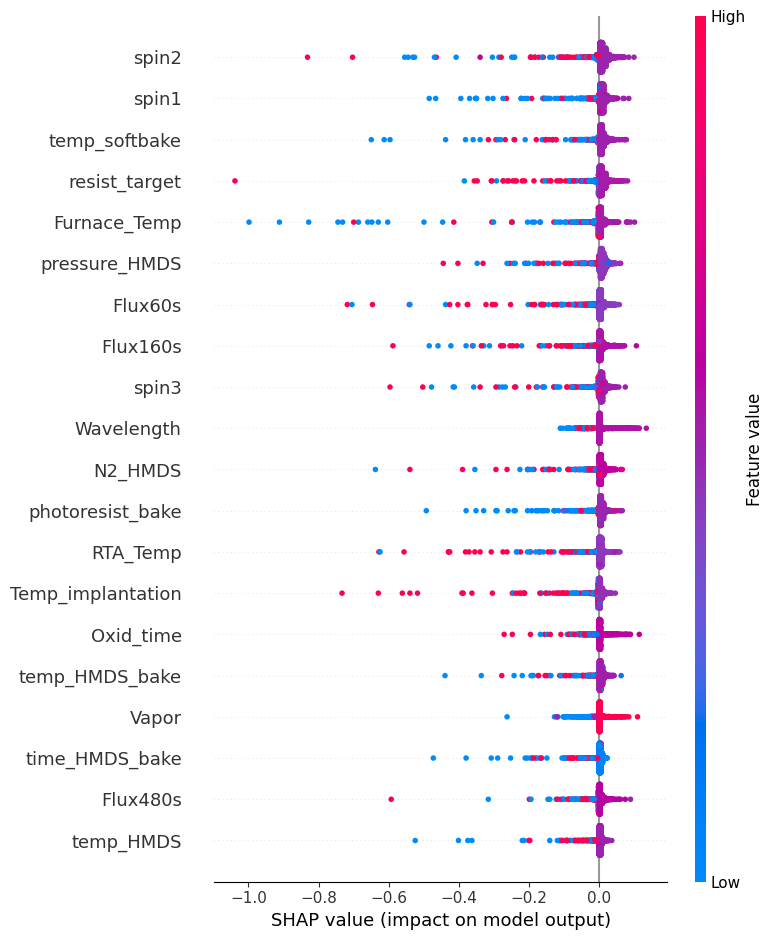

|   iter    |  target   |  Flux60s  | Pressure  | Temp_i... |
-------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
| 1         | -5.392    | 2.498e+16 | 0.9556    | 112.0     |
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
| 2         | -0.7937   | 3.395e+16 | 0.2404    | 94.68     |
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
| 3         | -4.585    | 1.232e+16 | 0.8796    | 108.0     |
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
| 4         | -1.586    | 3.832e+16 | 0.1185    | 119.1     |
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
| 5         | -1.247    | 4.33e+16  | 0.2911    | 95.45     |
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
| 6         | -4.082    | 4.885e+16 | 0.6692    | 119.6     |
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
| 7         | -2.098    | 1.643e+16 | 0.4591    | 92.6      |
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
| 8         | -2.593    | 2.301e+16 | 0.5312    | 94.28     |
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
| 9         | -2.149    | 4.772e+16 | 

In [8]:
# 📌 4️⃣ Isolation Forest 기반 이상 탐지
iso_forest = IsolationForest(contamination=0.02, random_state=42)
iso_forest.fit(X_train)

iso_predictions = iso_forest.predict(X_test)
iso_anomalies = iso_predictions == -1
print(f"🔍 Isolation Forest 감지된 이상치 개수: {sum(iso_anomalies)} / {len(iso_anomalies)}")

# 📌 5️⃣ Autoencoder vs Isolation Forest 비교
common_anomalies = sum(anomalies & iso_anomalies)
print(f"🔍 Autoencoder & Isolation Forest 공통 감지 이상치 개수: {common_anomalies} / {len(anomalies)}")

df_anomalies = df_all.iloc[np.where(anomalies)[0]]
df_iso_anomalies = df_all.iloc[np.where(iso_anomalies)[0]]
df_common_anomalies = df_all.iloc[np.where(anomalies & iso_anomalies)[0]]

display(df_anomalies.head(10))
display(df_iso_anomalies.head(10))
display(df_common_anomalies.head(10))

X_test_df = pd.DataFrame(X_test, columns=X.columns)  # 칼럼명을 유지하도록 변환

# 📌 SHAP Explainer 적용 (Isolation Forest은 TreeExplainer 지원 안 됨 → PermutationExplainer 사용)
explainer = shap.Explainer(iso_forest.predict, X_test)  # 적절한 Explainer 자동 선택
shap_values = explainer(X_test_df)  # DataFrame 입력 (칼럼 유지)

# 📌 SHAP Summary Plot (칼럼명을 유지)
shap.summary_plot(shap_values.values, X_test_df, feature_names=X_test_df.columns)  # 칼럼명 유지

# 📌 Bayesian Optimization을 활용한 최적 공정 조건 탐색 (오류 해결)
def objective_function(Flux60s, Temp_implantation, Pressure):
    # 선택된 변수만을 포함하는 데이터프레임 생성
    test_sample = pd.DataFrame([[Flux60s, Temp_implantation, Pressure]],
                               columns=['Flux60s', 'Temp_implantation', 'Pressure'])

    # 전체 변수 구조를 유지한 상태에서 특정 변수만 업데이트
    test_sample_full = pd.DataFrame(np.tile(X.mean().values, (1, 1)), columns=X.columns)  # 기존 변수 유지
    test_sample_full[['Flux60s', 'Temp_implantation', 'Pressure']] = test_sample.values  # 특정 변수 값 업데이트

    # StandardScaler 적용
    test_sample_scaled = scaler.transform(test_sample_full)

    # Autoencoder Reconstruction Error 계산
    reconstruction_error = np.mean(np.abs(autoencoder.predict(test_sample_scaled) - test_sample_scaled), axis=1)

    return -reconstruction_error[0]  # 오류가 작을수록 좋은 공정 조건

# 📌 Bayesian Optimization 실행 (오류 해결)
optimizer = BayesianOptimization(
    f=objective_function,
    pbounds={'Flux60s': (1e16, 5e16), 'Temp_implantation': (90, 120), 'Pressure': (0.1, 1.0)},
    random_state=42
)
optimizer.maximize()

# 📌 최적의 공정 조건 출력
print(f"🚀 최적 공정 조건: {optimizer.max['params']}")


In [10]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 📌 Google Drive 마운트 (필요한 경우 사용)
# from google.colab import drive
# drive.mount('/content/drive')

# 📌 Autoencoder 이상 탐지 결과를 Feature로 추가
df_all["is_anomaly"] = common_anomalies.astype(int)

# 📌 불량(Target ≥ 194) 여부를 라벨로 변환
y_binary = (df_all["Target"] >= 194).astype(int)

# 📌 Feature 선택 (숫자형 데이터 + 이상치 Feature 포함)
X = df_all.drop(columns=["Target"])
X = X.select_dtypes(include=['number'])  # ✅ 숫자형 데이터만 사용

# 📌 데이터 정규화
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 📌 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_binary, test_size=0.2, random_state=42)

# 📌 XGBoost 학습 (불균형 해결 포함)
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss",
                              scale_pos_weight=sum(y_train == 0) / sum(y_train == 1), random_state=42)
xgb_model.fit(X_train, y_train)

# 📌 모델 예측 (기본 Threshold 0.5)
y_pred_proba = xgb_model.predict_proba(X_test)[:, 1]

# 📌 Threshold 조정 (Recall 향상)
threshold = 0.4
y_pred_adjusted = (y_pred_proba >= threshold).astype(int)

# 📌 성능 평가
accuracy = accuracy_score(y_test, y_pred_adjusted)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred_adjusted)

# 📌 결과 출력
print(f"✅ XGBoost 정확도(Accuracy): {accuracy:.4f}")
print(f"✅ XGBoost ROC AUC Score: {roc_auc:.4f}")
print("✅ XGBoost 분류 리포트:\\n", report)


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[07:02:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




✅ XGBoost 정확도(Accuracy): 0.9008
✅ XGBoost ROC AUC Score: 0.8804
✅ XGBoost 분류 리포트:\n               precision    recall  f1-score   support

           0       0.98      0.91      0.95      1595
           1       0.36      0.73      0.49       109

    accuracy                           0.90      1704
   macro avg       0.67      0.82      0.72      1704
weighted avg       0.94      0.90      0.92      1704



#실시간 이상 탐지 시스템을 고도화하여 자동 공정 조정
✅ 기존 Autoencoder 기반 이상 탐지
✅ Isolation Forest와 비교 분석
✅ SHAP 분석을 활용한 중요 변수 확인
✅ Bayesian Optimization을 통해 최적 공정 도출
✅ 💡 실시간 이상 감지 시스템 고도화 (트렌드 분석 + 자동 공정 조정 기능 추가)



Epoch 1/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 1.0480 - val_loss: 0.9663
Epoch 2/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.9287 - val_loss: 0.8958
Epoch 3/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.8637 - val_loss: 0.8691
Epoch 4/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8317 - val_loss: 0.8612
Epoch 5/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.8200 - val_loss: 0.8518
Epoch 6/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.8249 - val_loss: 0.8467
Epoch 7/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8306 - val_loss: 0.8421
Epoch 8/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.8186 - val_loss: 0.8372
Epoch 9/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.8179 - val_loss: 0.8361
Epoch 10/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.8194 - val_loss: 0.8325
Epoch 11/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.8006 - val_loss: 0.8305
Epoch 12/50
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


⚠️ 이상 감지 (재구성 오류: 16216216216223958.00000) → 즉시 공정 점검 필요
🔍 [실시간 감지 2/10]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


⚠️ 이상 감지 (재구성 오류: 16216216216223924.00000) → 즉시 공정 점검 필요
🔍 [실시간 감지 3/10]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
⚠️ 이상 감지 (재구성 오류: 16216216216223892.00000) → 즉시 공정 점검 필요


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


🔍 [실시간 감지 4/10]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


⚠️ 이상 감지 (재구성 오류: 16216216216223914.00000) → 즉시 공정 점검 필요
🔍 [실시간 감지 5/10]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


⚠️ 이상 감지 (재구성 오류: 16216216216223942.00000) → 즉시 공정 점검 필요
🔍 [실시간 감지 6/10]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


⚠️ 이상 감지 (재구성 오류: 16216216216223962.00000) → 즉시 공정 점검 필요
🔍 [실시간 감지 7/10]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
⚠️ 이상 감지 (재구성 오류: 16216216216223944.00000) → 즉시 공정 점검 필요


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


🔍 [실시간 감지 8/10]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
⚠️ 이상 감지 (재구성 오류: 16216216216223920.00000) → 즉시 공정 점검 필요


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


🔍 [실시간 감지 9/10]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
⚠️ 이상 감지 (재구성 오류: 16216216216223890.00000) → 즉시 공정 점검 필요


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


🔍 [실시간 감지 10/10]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
⚠️ 이상 감지 (재구성 오류: 16216216216223892.00000) → 즉시 공정 점검 필요


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


✅ 실시간 감지 종료 (10회 수행 완료)


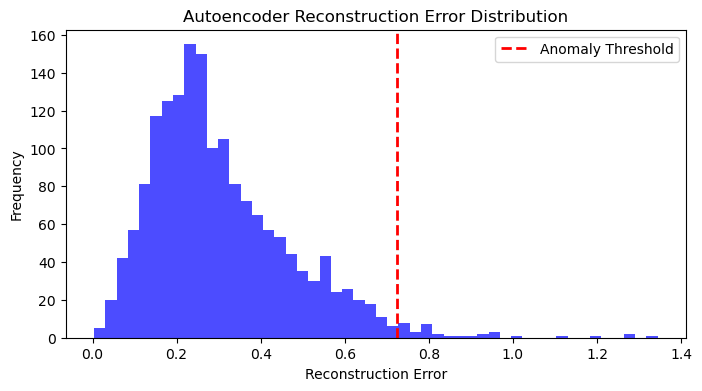

In [ ]:
import numpy as np
import pandas as pd
import time
import tensorflow as tf
from tensorflow import keras
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt

# 📌 1️⃣ 데이터 로드 및 전처리
ion_file = 'Ion_Implantation.csv'
oxidation_file = 'Oxidation.csv'
lithography_file = 'Photo_lithograpy.csv'
softbake_file = 'Photo_softbake.csv'
etching_file = 'Etching.csv'
quality_file = 'Qualitylnspection.csv'

df_dict = {
    "Ion": pd.read_csv(ion_file).rename(columns={'Furance_Temp': 'Furnace_Temp'}),
    "Oxidation": pd.read_csv(oxidation_file),
    "Lithography": pd.read_csv(lithography_file).rename(columns={'Process 2-1': 'process'}),
    "Softbake": pd.read_csv(softbake_file).rename(columns={'Process 2': 'process'}),
    "Etching": pd.read_csv(etching_file).rename(columns={'Process 3': 'process'}),
    "Quality": pd.read_csv(quality_file)
}

df_quality = df_dict["Quality"][['No_Die', 'Lot_Num', 'Wafer_Num', 'Target']]
for key in df_dict:
    if key != "Quality":
        df_dict[key] = df_dict[key].merge(df_quality, on=['No_Die', 'Lot_Num', 'Wafer_Num'], how='left')

selected_features = {
    "Ion": ['Flux60s', 'Flux90s', 'Flux160s', 'Flux480s', 'Flux840s', 'input_Energy', 'Temp_implantation', 'Furnace_Temp', 'RTA_Temp'],
    "Oxidation": ['Temp_Oxid', 'Vapor', 'ppm', 'Pressure', 'Oxid_time', 'thickness'],
    "Lithography": ['Wavelength', 'Resolution', 'Energy_Exposure', 'Line_CD'],
    "Softbake": ['N2_HMDS', 'pressure_HMDS', 'temp_HMDS', 'temp_HMDS_bake', 'time_HMDS_bake', 'spin1', 'spin2', 'spin3', 'photoresist_bake', 'temp_softbake', 'time_softbake', 'resist_target'],
    "Etching": ['Source_Power', 'Selectivity', 'Temp_Etching', 'Thin F1', 'Thin F2', 'Thin F3', 'Thin F4']
}

df_all_list = []
for key in selected_features:
    valid_columns = [col for col in selected_features[key] if col in df_dict[key].columns]
    df_all_list.append(df_dict[key][valid_columns + ['Target']])
df_all = pd.concat(df_all_list, axis=0)

categorical_cols = ['Vapor', 'process', 'type', 'UV_type']
encoder = LabelEncoder()
for col in categorical_cols:
    if col in df_all.columns:
        df_all[col] = encoder.fit_transform(df_all[col].astype(str))

df_all.fillna(df_all.mean(numeric_only=True), inplace=True)

scaler = StandardScaler()
X = df_all.drop(columns=['Target'])
y = df_all['Target'].fillna(0)
X_scaled = scaler.fit_transform(X)
X_train, X_test = train_test_split(X_scaled, test_size=0.2, random_state=42)

# 📌 2️⃣ Autoencoder 기반 이상 탐지 모델 구축
input_dim = X_train.shape[1]
autoencoder = keras.Sequential([
    keras.layers.Input(shape=(input_dim,)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(8, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(input_dim, activation='sigmoid')
])
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, validation_data=(X_test, X_test), verbose=1)

# 📌 3️⃣ Isolation Forest 기반 이상 탐지
iso_forest = IsolationForest(contamination=0.02, random_state=42)
iso_forest.fit(X_train)
iso_predictions = iso_forest.predict(X_test)
iso_anomalies = iso_predictions == -1
print(f"🔍 Isolation Forest 감지된 이상치 개수: {sum(iso_anomalies)} / {len(iso_anomalies)}")

# 📌 4️⃣ Autoencoder vs Isolation Forest 비교
reconstructed = autoencoder.predict(X_test)
reconstruction_error = np.mean(np.abs(X_test - reconstructed), axis=1)
threshold = np.percentile(reconstruction_error, 98)
anomalies = reconstruction_error > threshold
common_anomalies = sum(anomalies & iso_anomalies)
print(f"🔍 Autoencoder & Isolation Forest 공통 감지 이상치 개수: {common_anomalies} / {len(anomalies)}")

# 📌 5️⃣ 실시간 이상 탐지 시스템 (10회 반복 후 종료)
def real_time_monitoring(new_data):
    new_data_scaled = scaler.transform(new_data)
    reconstruction_error = np.mean(np.abs(autoencoder.predict(new_data_scaled) - new_data_scaled), axis=1)

    if reconstruction_error > threshold:
        print(f"⚠️ 이상 감지 (재구성 오류: {reconstruction_error[0]:.5f}) → 즉시 공정 점검 필요")
    else:
        print(f"✅ 정상 공정 (재구성 오류: {reconstruction_error[0]:.5f})")

for i in range(10):
    print(f"🔍 [실시간 감지 {i+1}/10]")
    new_data = np.random.rand(1, X.shape[1])
    real_time_monitoring(new_data)
    time.sleep(2)

print("✅ 실시간 감지 종료 (10회 수행 완료)")

# 📌 6️⃣ 시각화 (이상 감지 데이터 분석)
plt.figure(figsize=(8, 4))
plt.hist(reconstruction_error, bins=50, color='blue', alpha=0.7)
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label="Anomaly Threshold")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.title("Autoencoder Reconstruction Error Distribution")
plt.legend()
plt.show()


📌 점이연 상관분석 및 최적 공정 도출 분석 개요
점이연 상관분석 진행

각 불량 유형별로 [특정 불량 유형 vs 나머지 모든 데이터] 방식으로 점이연 상관분석을 수행
p-value < 0.05인 변수들은 별표(*)로 표시
히트맵 시각화

점이연 상관분석 결과에서 p-value < 0.05 이하인 변수들만 히트맵으로 시각화
반복문을 사용하여 모든 유형을 한 번에 분석

최적 공정 도출 (Bayesian Optimization 적용)

각 유형별 상관계수과 높은 공정들을 따로 뽑아 Bayesian Optimization을 활용하여 최적의 공정 조건을 도출

In [ ]:
# 📌 [데이터 전처리 단계]
# 반도체 공정의 품질 검사 데이터(df_qi)를 정리하고 필요한 형식으로 변환
# 📌 [라이브러리 호출]
# 데이터 분석, 통계, 시각화를 위한 필수 라이브러리 불러오기

import pandas as pd  # 데이터 분석 및 조작을 위한 라이브러리 (엑셀, CSV 등 파일 처리)
import matplotlib as mpl  # 그래프 관련 설정 (글꼴, 크기 등)
import matplotlib.pyplot as plt  # 그래프 시각화를 위한 라이브러리
import seaborn as sns  # 고급 시각화 라이브러리 (히트맵, 상자 그림 등)
import scipy.stats as stats  # 통계 분석 라이브러리 (점이연상관분석, T-test 등)
import plotly.express as px  # 인터랙티브한 그래프 생성 (3D 플롯, 지도 시각화 등)
import matplotlib.font_manager as fm  # 글꼴 설정을 위한 라이브러리

# 📌 [한글 글꼴 설정]
mpl.rc('font', family='Malgun Gothic')
# → matplotlib의 기본 글꼴을 "Malgun Gothic" (맑은 고딕)으로 설정하여 한글이 깨지지 않도록 함

# 📌 [데이터 불러오기]
df_qi = pd.read_csv('Qualitylnspection.csv')
# → 'Qualitylnspection.csv' 파일을 Pandas 데이터프레임(df_qi)으로 불러옴
# 📌 1️⃣ 특정 인덱스 행 삭제 (1704~1717번 데이터 제거)
df_qi_ne = df_qi.drop(labels=range(1704, 1718), axis=0)
# → 1704~1717번 행을 삭제하여 데이터 정리
# → 불필요하거나 오류가 포함된 행일 가능성이 높음

# 📌 2️⃣ 첫 번째 컬럼 삭제
df_qi_new = df_qi_ne.drop(df_qi.columns[0], axis=1)
# → 데이터의 첫 번째 컬럼을 삭제 (보통 인덱스 번호 또는 불필요한 ID 컬럼일 가능성 있음)

# 📌 3️⃣ Pandas 옵션 설정 (경고 방지)
pd.set_option('future.no_silent_downcasting', True)
# → `future.no_silent_downcasting` 옵션을 설정하여 자동 데이터 타입 변경 시 발생하는 **FutureWarning을 방지**
# → 데이터 타입 변환이 명확하게 적용되도록 설정

# 📌 4️⃣ 불량 유형 매핑 (텍스트 → 숫자 변환)
error_mapping = {
    'none': 0,                 # 불량 없음 → 0
    "[['Edge-Loc']]": 1,       # Edge-Loc 불량 → 1
    "[['Loc']]": 2,            # Loc 불량 → 2
    "[['Random']]": 3,         # Random 불량 → 3
    "[['Center']]": 4,         # Center 불량 → 4
    "[['Scratch']]": 5,        # Scratch 불량 → 5
    "[['Near-full']]": 6,      # Near-full 불량 → 6
    "[['Edge-Ring']]": 7       # Edge-Ring 불량 → 7
}
# → Error_message 컬럼의 텍스트 값을 숫자로 변환 (모델 학습 및 분석을 쉽게 하기 위함)

# 📌 5️⃣ 불량 유형을 숫자로 변환 후, 데이터 타입 변환
df_qi_new['불량'] = df_qi_new['Error_message'].replace(error_mapping)
# → 매핑된 숫자로 변환하여 '불량' 컬럼 생성

df_qi_new = df_qi_new.infer_objects(copy=False)
# → 자동으로 데이터 타입을 추론하여 최적화 (downcasting 방지)

df_qi_new['불량'] = df_qi_new['불량'].astype(int)
# → '불량' 컬럼을 명확한 **정수형(int)** 데이터로 변환

# 📌 6️⃣ 피벗 테이블 생성 (No_Die, Lot_Num, Wafer_Num 기준 그룹화)
df_qi_all = df_qi_new.pivot_table(index=['No_Die', 'Lot_Num', 'Wafer_Num'], values='불량')
# → 'No_Die', 'Lot_Num', 'Wafer_Num' 별로 **불량 유형 데이터를 그룹화**
# → 특정 웨이퍼/로트에서 발생한 불량을 분석하기 쉽게 변환



In [ ]:
# 📌 [라이브러리 임포트]
import pandas as pd  # 데이터 분석을 위한 Pandas 라이브러리
import matplotlib.pyplot as plt  # 데이터 시각화를 위한 Matplotlib
import seaborn as sns  # 고급 시각화를 위한 Seaborn
import numpy as np  # 수학 연산을 위한 NumPy
import matplotlib.font_manager as fm  # 한글 폰트 설정을 위한 라이브러리
from scipy.stats import pointbiserialr  # 점이연상관분석(Point-Biserial Correlation)을 위한 라이브러리

# 📌 [한글 글꼴 설정]
mpl.rc('font', family='Malgun Gothic')
# → matplotlib의 기본 글꼴을 "Malgun Gothic" (맑은 고딕)으로 설정하여 한글이 깨지지 않도록 함

# 📌 [데이터 불러오기]
df_qi = pd.read_csv('Qualitylnspection.csv')
# → 'Qualitylnspection.csv' 파일을 Pandas 데이터프레임(df_qi)으로 불러옴


# 📌 [폰트 설정]
font_path = 'C:/Windows/Fonts/malgun.ttf'  # Windows 환경에서 'Malgun Gothic' 폰트 경로 설정
font_name = fm.FontProperties(fname=font_path).get_name()  # 폰트 가져오기
plt.rc('font', family=font_name)  # Matplotlib에서 폰트 설정 (한글 깨짐 방지)

# 📌 [CSV 파일 로드]
# → 각 공정별 데이터를 로드하고, index_col=0을 사용해 불필요한 인덱스 컬럼 제거
df_oxi = pd.read_csv('Oxidation.csv', index_col=0)  # 산화 공정 데이터
df_li = pd.read_csv('Photo_lithograpy.csv', index_col=0)  # 포토 리소그래피(광학 공정) 데이터
df_soft = pd.read_csv('Photo_softbake.csv', index_col=0)  # 소프트 베이크 공정 데이터
df_Ion = pd.read_csv('Ion_Implantation.csv', index_col=0)  # 이온 임플란테이션(이온 주입) 공정 데이터
df_Etch = pd.read_csv('Etching.csv', index_col=0)  # 에칭 공정 데이터

# 📌 [Datetime 컬럼 삭제]
# → 각 데이터프레임에서 'Datetime' 컬럼이 존재하면 삭제 (불필요한 시간 정보 제거)
for df in [df_oxi, df_li, df_soft, df_Ion, df_Etch]:
    if 'Datetime' in df.columns:  # 'Datetime' 컬럼이 존재하는 경우
        df.drop(columns=['Datetime'], inplace=True)  # 해당 컬럼 삭제

# 📌 [데이터 병합]
# → df_qi_all(품질 검사 데이터)을 기준으로 공정 데이터를 병합 (inner join 사용)
df_all = (df_qi_all
             .merge(df_oxi, on=['No_Die', 'Lot_Num', 'Wafer_Num'], how='inner')  # 산화 공정 데이터 병합
             .merge(df_li, on=['No_Die', 'Lot_Num', 'Wafer_Num'], how='inner')  # 포토 리소그래피 데이터 병합
             .merge(df_soft, on=['No_Die', 'Lot_Num', 'Wafer_Num'], how='inner')  # 소프트 베이크 데이터 병합
             .merge(df_Ion, on=['No_Die', 'Lot_Num', 'Wafer_Num'], how='inner')  # 이온 임플란테이션 데이터 병합
             .merge(df_Etch, on=['No_Die', 'Lot_Num', 'Wafer_Num'], how='inner')  # 에칭 공정 데이터 병합
)

# 📌 [병합 후 'Datetime' 중복 컬럼 제거]
# → 병합 과정에서 중복으로 생성된 'Datetime_x', 'Datetime_y' 컬럼이 있다면 제거
df_all = df_all.loc[:, ~df_all.columns.str.contains('Datetime')]

# 📌 [데이터프레임 확인]
df_all  # 최종 병합된 데이터프레임 출력


,No_Die,Lot_Num,Wafer_Num,불량,Ox_Chamber,process,type,Temp_OXid,Vapor,ppm,...,RTA_Temp,Etching_Chamber,Process 3,Thin F4,Thin F3,Thin F2,Thin F1,Temp_Etching,Source_Power,Selectivity
0,NOLSM100419,4.0,19.0,0.0,1,Oxidation,dry,1041.249438,O2,33.55,...,149,2,Etching,357.0,1411.0,3668.0,5720.0,72.288,50.875,1.036
1,NOLSM100419100,4.0,46.0,0.0,2,Oxidation,dry,1054.129737,O2,33.55,...,149,1,Etching,357.0,1411.0,3668.0,5720.0,72.288,50.875,1.036
2,NOLSM10110,1.0,10.0,0.0,2,Oxidation,wet,1104.836285,H2O,34.95,...,158,2,Etching,466.0,1603.0,3643.0,5703.0,69.948,50.944,1.024
3,NOLSM1011010,1.0,37.0,0.0,1,Oxidation,wet,1117.020887,H2O,34.95,...,158,1,Etching,466.0,1603.0,3643.0,5703.0,69.948,50.944,1.024
4,NOLSM101420,4.0,20.0,0.0,1,Oxidation,wet,1113.101915,H2O,41.09,...,155,1,Etching,405.0,1584.0,3660.0,5732.0,70.823,50.187,1.036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1699,NOLSM9741697,4.0,43.0,0.0,2,Oxidation,dry,882.925356,O2,44.49,...,156,1,Etching,382.0,1495.0,3663.0,5727.0,71.402,50.650,1.027
1700,NOLSM98417,4.0,17.0,0.0,3,Oxidation,dry,1199.230883,O2,30.89,...,153,3,Etching,285.0,1507.0,3630.0,5718.0,72.434,50.433,1.047
1701,NOLSM9841798,4.0,44.0,0.0,2,Oxidation,dry,1218.223115,O2,30.89,...,153,2,Etching,285.0,1507.0,3630.0,5718.0,71.287,50.433,1.047
1702,NOLSM99418,4.0,18.0,1.0,1,Oxidation,dry,1019.398602,O2,36.17,...,154,3,Etching,334.0,1295.0,3686.0,5688.0,72.783,51.061,1.045



========== Dry Oxidation, 불량 유형 1.0 점이연상관분석 ==========
- Ox_Chamber: 상관계수 = 0.0387, p-value = 0.2238
- Temp_OXid: 상관계수 = -0.0678, p-value = 0.0330 **⭐**
- ppm: 상관계수 = -0.0702, p-value = 0.0271 **⭐**
- Pressure: 상관계수 = 0.1119, p-value = 0.0004 **⭐**
- Oxid_time: 상관계수 = 0.0032, p-value = 0.9201
- thickness: 상관계수 = 0.1357, p-value = 0.0000 **⭐**

========== Wet Oxidation, 불량 유형 1.0 점이연상관분석 ==========
- Ox_Chamber: 상관계수 = -0.0143, p-value = 0.7027
- Temp_OXid: 상관계수 = -0.0052, p-value = 0.8903
- ppm: 상관계수 = 0.0239, p-value = 0.5229
- Pressure: 상관계수 = -0.0245, p-value = 0.5130
- Oxid_time: 상관계수 = 0.0424, p-value = 0.2581
- thickness: 상관계수 = 0.0287, p-value = 0.4445

========== Etching 공정, 불량 유형 1.0 점이연상관분석 ==========
- Etching_Chamber: 상관계수 = 0.0354, p-value = 0.1439
- Thin F4: 상관계수 = 0.2494, p-value = 0.0000 **⭐**
- Thin F3: 상관계수 = 0.1058, p-value = 0.0000 **⭐**
- Thin F2: 상관계수 = 0.1996, p-value = 0.0000 **⭐**
- Thin F1: 상관계수 = 0.0069, p-value = 0.7759
- Source_Power: 상관계수 = 0.0439, p-valu

C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:5535: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


- N2_HMDS: 상관계수 = -0.0274, p-value = 0.2580
- pressure_HMDS: 상관계수 = -0.0120, p-value = 0.6209
- temp_HMDS: 상관계수 = -0.0078, p-value = 0.7487
- temp_HMDS_bake: 상관계수 = -0.0756, p-value = 0.0018 **⭐**
- time_HMDS_bake: 상관계수 = -0.0495, p-value = 0.0412 **⭐**
- spin1: 상관계수 = -0.0759, p-value = 0.0017 **⭐**
- spin2: 상관계수 = -0.0442, p-value = 0.0684
- spin3: 상관계수 = -0.0783, p-value = 0.0012 **⭐**
- photoresist_bake: 상관계수 = -0.1023, p-value = 0.0000 **⭐**
- temp_softbake: 상관계수 = -0.1111, p-value = 0.0000 **⭐**
- time_softbake: 상관계수 = -0.0246, p-value = 0.3099

========== Dry Oxidation, 불량 유형 2.0 점이연상관분석 ==========
- Ox_Chamber: 상관계수 = -0.0035, p-value = 0.9126
- Temp_OXid: 상관계수 = -0.0912, p-value = 0.0041 **⭐**
- ppm: 상관계수 = -0.0304, p-value = 0.3392
- Pressure: 상관계수 = 0.1408, p-value = 0.0000 **⭐**
- Oxid_time: 상관계수 = 0.0158, p-value = 0.6197
- thickness: 상관계수 = 0.1220, p-value = 0.0001 **⭐**

========== Wet Oxidation, 불량 유형 2.0 점이연상관분석 ==========
- Ox_Chamber: 상관계수 = -0.0158, p-value = 0.6733

C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:5535: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


- Ox_Chamber: 상관계수 = 0.0561, p-value = 0.0774
- Temp_OXid: 상관계수 = -0.0369, p-value = 0.2456
- ppm: 상관계수 = -0.0200, p-value = 0.5305
- Pressure: 상관계수 = 0.1295, p-value = 0.0000 **⭐**
- Oxid_time: 상관계수 = 0.0330, p-value = 0.2997
- thickness: 상관계수 = 0.1161, p-value = 0.0003 **⭐**

========== Wet Oxidation, 불량 유형 3.0 점이연상관분석 ==========
- Ox_Chamber: 상관계수 = -0.0282, p-value = 0.4520
- Temp_OXid: 상관계수 = 0.0513, p-value = 0.1713
- ppm: 상관계수 = 0.0498, p-value = 0.1838
- Pressure: 상관계수 = 0.0278, p-value = 0.4581
- Oxid_time: 상관계수 = -0.0449, p-value = 0.2310
- thickness: 상관계수 = 0.0124, p-value = 0.7416

========== Etching 공정, 불량 유형 3.0 점이연상관분석 ==========
- Etching_Chamber: 상관계수 = -0.0251, p-value = 0.3007
- Thin F4: 상관계수 = 0.0561, p-value = 0.0206 **⭐**
- Thin F3: 상관계수 = 0.0728, p-value = 0.0027 **⭐**
- Thin F2: 상관계수 = 0.0868, p-value = 0.0003 **⭐**
- Thin F1: 상관계수 = -0.0553, p-value = 0.0227 **⭐**
- Source_Power: 상관계수 = 0.0073, p-value = 0.7642
- Selectivity: 상관계수 = -0.0129, p-value = 0.5951

=

C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:5535: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


- input_Energy: 상관계수 = 0.0181, p-value = 0.4543
- Temp_implantation: 상관계수 = -0.0096, p-value = 0.6922
- Furance_Temp: 상관계수 = -0.0275, p-value = 0.2561
- RTA_Temp: 상관계수 = -0.0202, p-value = 0.4055

========== Lithography 공정, 불량 유형 3.0 점이연상관분석 ==========
- Line_CD: 상관계수 = 0.0539, p-value = 0.0261 **⭐**
- Wavelength: 상관계수 = -0.0030, p-value = 0.9022
- Resolution: 상관계수 = -0.0272, p-value = 0.2620
- Energy_Exposure: 상관계수 = 0.0060, p-value = 0.8037

========== Softbake 공정, 불량 유형 3.0 점이연상관분석 ==========
- resist_target: 상관계수 = 0.0658, p-value = 0.0066 **⭐**
- N2_HMDS: 상관계수 = 0.0194, p-value = 0.4234
- pressure_HMDS: 상관계수 = -0.0024, p-value = 0.9205
- temp_HMDS: 상관계수 = -0.0191, p-value = 0.4318
- temp_HMDS_bake: 상관계수 = -0.0773, p-value = 0.0014 **⭐**
- time_HMDS_bake: 상관계수 = 0.0403, p-value = 0.0966
- spin1: 상관계수 = -0.0873, p-value = 0.0003 **⭐**
- spin2: 상관계수 = -0.0645, p-value = 0.0077 **⭐**
- spin3: 상관계수 = -0.0939, p-value = 0.0001 **⭐**
- photoresist_bake: 상관계수 = -0.0930, p-value = 0.0001 *

C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:5535: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:5535: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


- Ox_Chamber: 상관계수 = nan, p-value = nan
- Temp_OXid: 상관계수 = nan, p-value = nan
- ppm: 상관계수 = nan, p-value = nan
- Pressure: 상관계수 = nan, p-value = nan
- Oxid_time: 상관계수 = nan, p-value = nan
- thickness: 상관계수 = nan, p-value = nan

========== Etching 공정, 불량 유형 4.0 점이연상관분석 ==========
- Etching_Chamber: 상관계수 = 0.0202, p-value = 0.4048
- Thin F4: 상관계수 = 0.0769, p-value = 0.0015 **⭐**
- Thin F3: 상관계수 = 0.0395, p-value = 0.1035
- Thin F2: 상관계수 = 0.0155, p-value = 0.5215
- Thin F1: 상관계수 = -0.0308, p-value = 0.2043
- Source_Power: 상관계수 = 0.0317, p-value = 0.1905
- Selectivity: 상관계수 = 0.0201, p-value = 0.4068

========== Ion Implantation 공정, 불량 유형 4.0 점이연상관분석 ==========
- Flux60s: 상관계수 = -0.0084, p-value = 0.7280
- Flux90s: 상관계수 = 0.0132, p-value = 0.5870
- Flux160s: 상관계수 = -0.0200, p-value = 0.4100
- Flux480s: 상관계수 = -0.0384, p-value = 0.1134
- Flux840s: 상관계수 = nan, p-value = nan
- input_Energy: 상관계수 = 0.0036, p-value = 0.8831
- Temp_implantation: 상관계수 = 0.0635, p-value = 0.0087 **⭐**
- Furance_

C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:5535: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


- temp_HMDS: 상관계수 = 0.0162, p-value = 0.5046
- temp_HMDS_bake: 상관계수 = 0.0164, p-value = 0.5000
- time_HMDS_bake: 상관계수 = 0.0181, p-value = 0.4545
- spin1: 상관계수 = 0.0212, p-value = 0.3822
- spin2: 상관계수 = 0.0246, p-value = 0.3095
- spin3: 상관계수 = 0.0031, p-value = 0.8992
- photoresist_bake: 상관계수 = -0.0165, p-value = 0.4965
- temp_softbake: 상관계수 = -0.0238, p-value = 0.3261
- time_softbake: 상관계수 = 0.0015, p-value = 0.9505

========== Dry Oxidation, 불량 유형 6.0 점이연상관분석 ==========
- Ox_Chamber: 상관계수 = 0.0294, p-value = 0.3547
- Temp_OXid: 상관계수 = -0.0433, p-value = 0.1738
- ppm: 상관계수 = -0.0472, p-value = 0.1377
- Pressure: 상관계수 = 0.0104, p-value = 0.7428
- Oxid_time: 상관계수 = 0.0040, p-value = 0.8989
- thickness: 상관계수 = -0.0118, p-value = 0.7104

========== Wet Oxidation, 불량 유형 6.0 점이연상관분석 ==========
- Ox_Chamber: 상관계수 = 0.0045, p-value = 0.9048
- Temp_OXid: 상관계수 = 0.0488, p-value = 0.1926
- ppm: 상관계수 = 0.0514, p-value = 0.1699
- Pressure: 상관계수 = 0.0385, p-value = 0.3045
- Oxid_time: 상관계수 = -0.0429

C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:5535: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)
C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:5535: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


- input_Energy: 상관계수 = 0.0223, p-value = 0.3576
- Temp_implantation: 상관계수 = 0.0189, p-value = 0.4350
- Furance_Temp: 상관계수 = -0.0227, p-value = 0.3501
- RTA_Temp: 상관계수 = 0.0161, p-value = 0.5060

========== Lithography 공정, 불량 유형 6.0 점이연상관분석 ==========
- Line_CD: 상관계수 = 0.0094, p-value = 0.6975
- Wavelength: 상관계수 = -0.0327, p-value = 0.1768
- Resolution: 상관계수 = -0.0433, p-value = 0.0741
- Energy_Exposure: 상관계수 = 0.0094, p-value = 0.6978

========== Softbake 공정, 불량 유형 6.0 점이연상관분석 ==========
- resist_target: 상관계수 = -0.0248, p-value = 0.3060
- N2_HMDS: 상관계수 = 0.0271, p-value = 0.2632
- pressure_HMDS: 상관계수 = -0.0079, p-value = 0.7455
- temp_HMDS: 상관계수 = -0.0199, p-value = 0.4122
- temp_HMDS_bake: 상관계수 = 0.0665, p-value = 0.0060 **⭐**
- time_HMDS_bake: 상관계수 = -0.0041, p-value = 0.8645
- spin1: 상관계수 = 0.0592, p-value = 0.0145 **⭐**
- spin2: 상관계수 = 0.0591, p-value = 0.0147 **⭐**
- spin3: 상관계수 = 0.0654, p-value = 0.0069 **⭐**
- photoresist_bake: 상관계수 = 0.0665, p-value = 0.0061 **⭐**
- temp_softb

C:\ProgramData\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:5535: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rpb, prob = pearsonr(x, y)


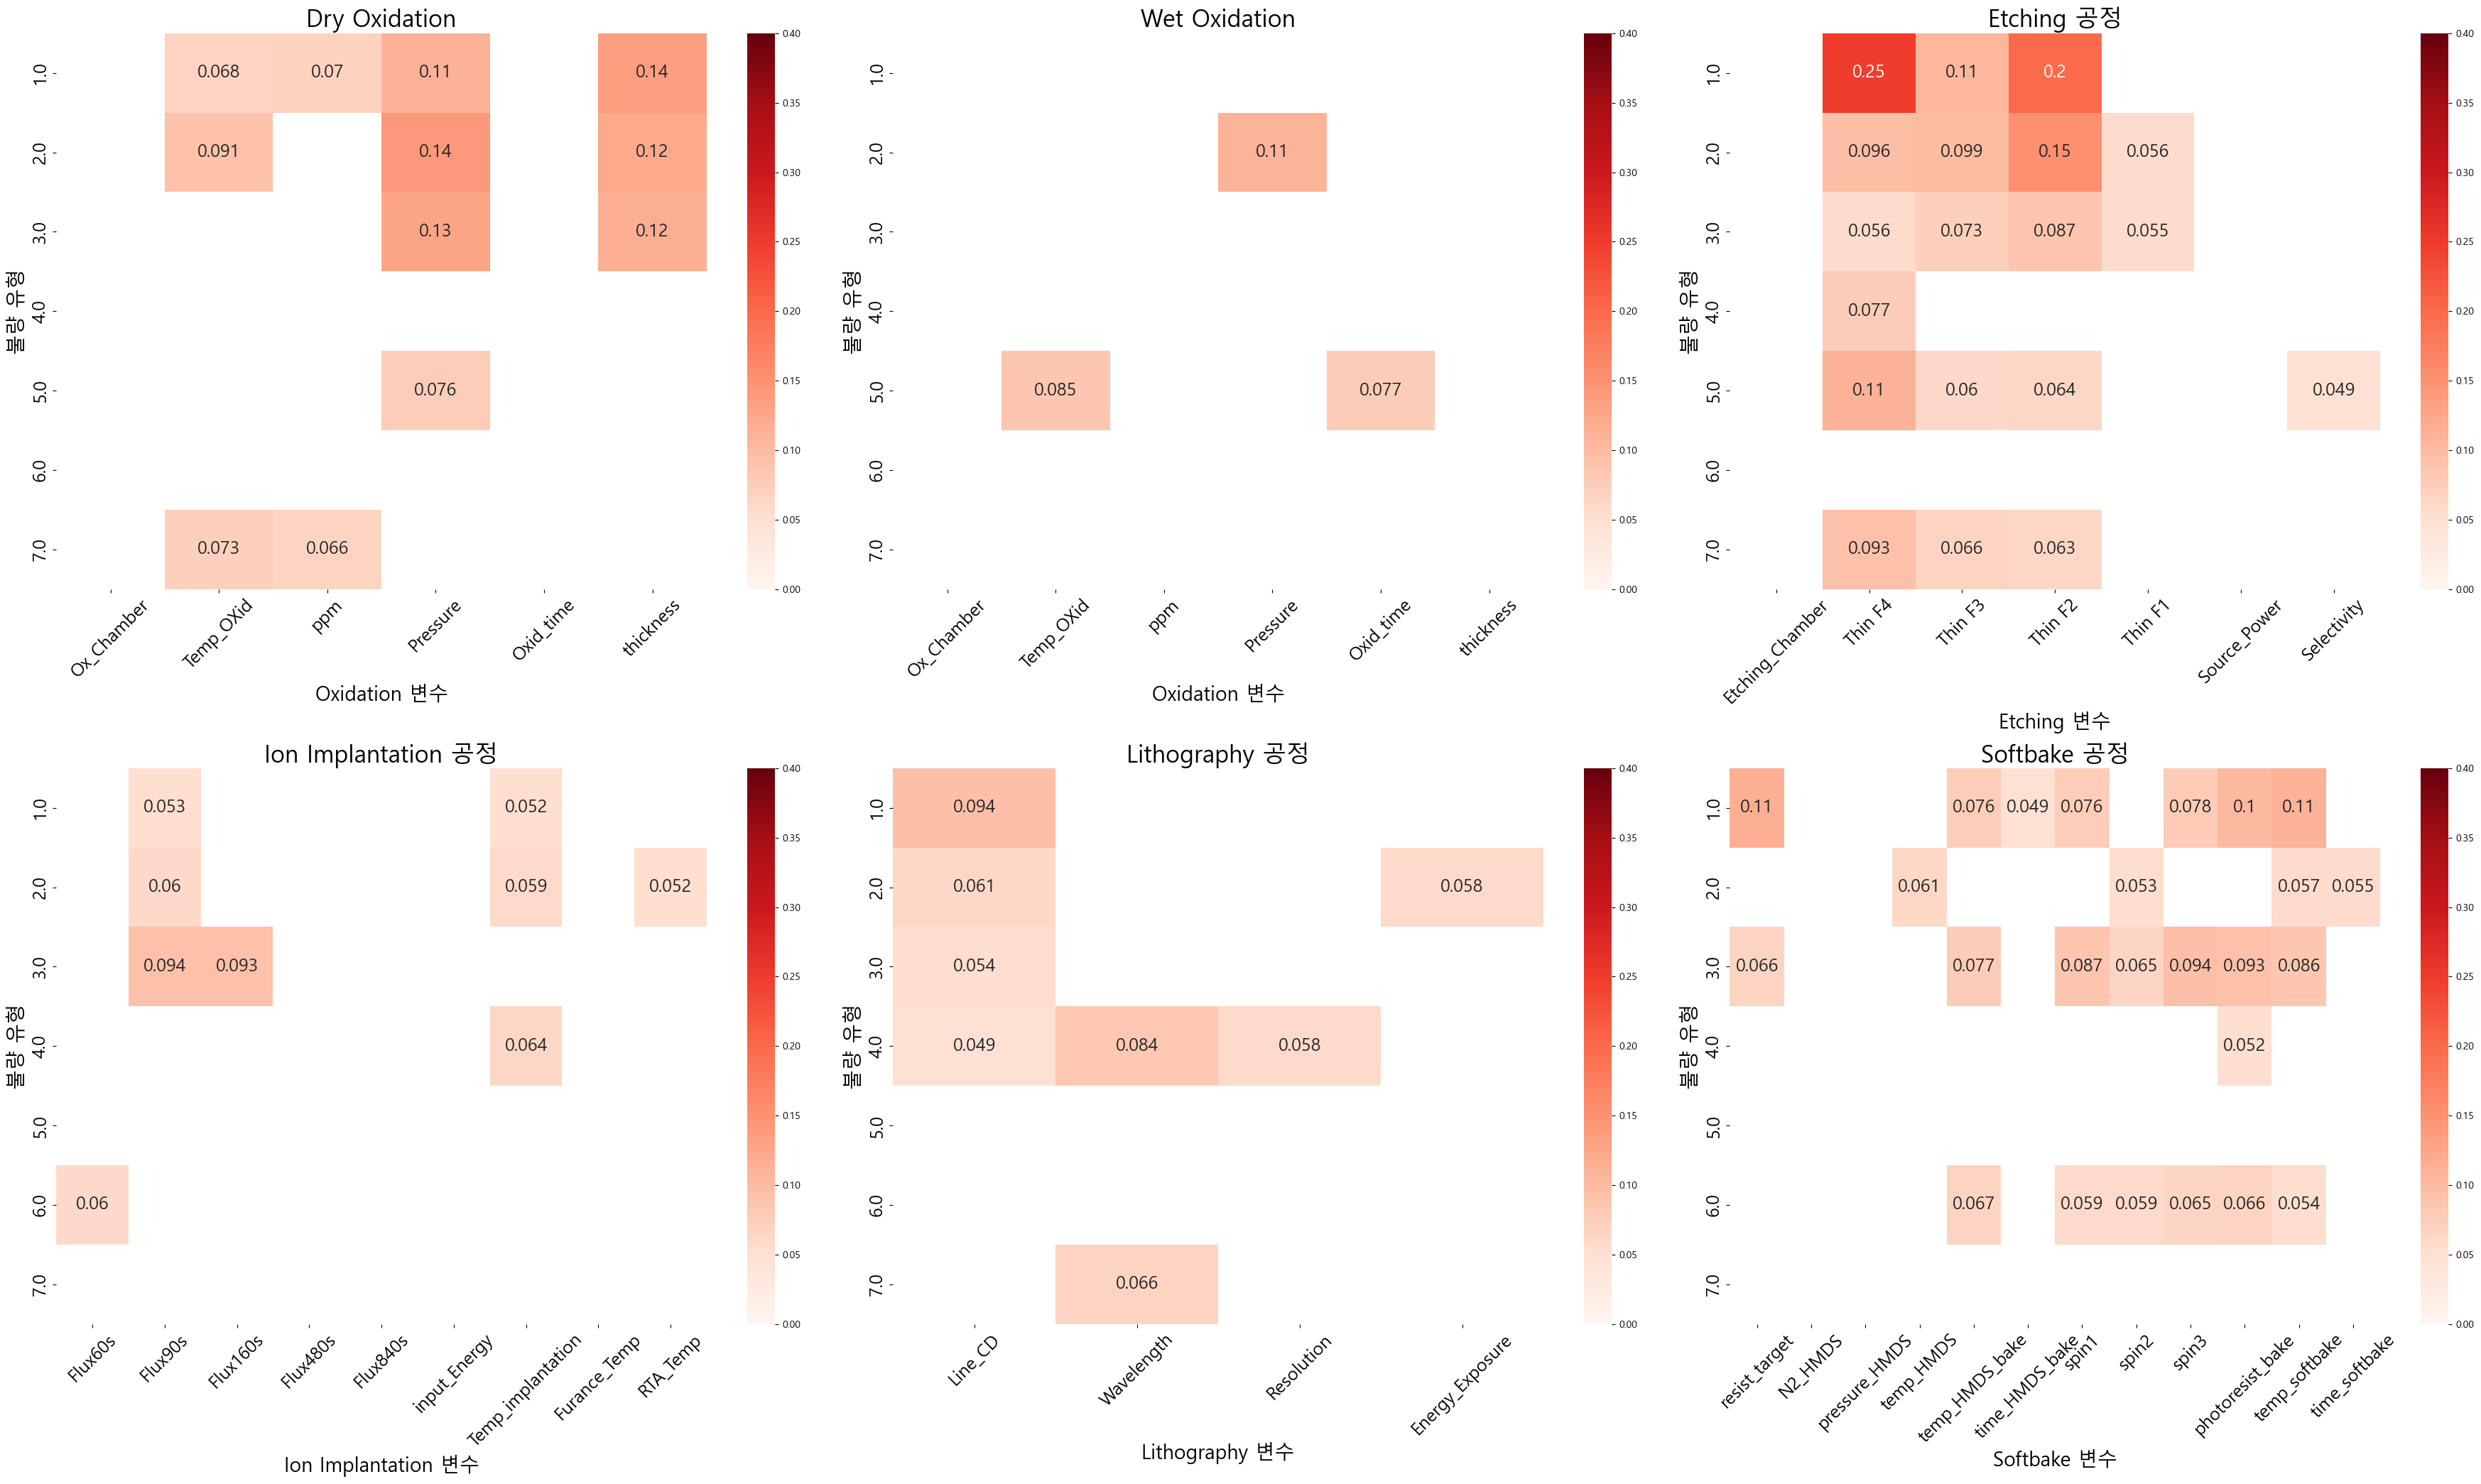

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pointbiserialr

# 📌 분석 대상 변수 설정 (각 공정별 변수 리스트)
oxidation_vars = ['Ox_Chamber', 'Temp_OXid', 'ppm', 'Pressure', 'Oxid_time', 'thickness']  # 산화 공정 변수
etching_vars = ['Etching_Chamber', 'Thin F4', 'Thin F3', 'Thin F2', 'Thin F1', 'Source_Power', 'Selectivity']  # 에칭 공정 변수
ion_vars = ['Flux60s', 'Flux90s', 'Flux160s', 'Flux480s', 'Flux840s', 'input_Energy', 'Temp_implantation', 'Furance_Temp', 'RTA_Temp']  # 이온 주입 공정 변수
litho_vars = ['Line_CD', 'Wavelength', 'Resolution', 'Energy_Exposure']  # 리소그래피 공정 변수
soft_vars = ['resist_target', 'N2_HMDS', 'pressure_HMDS', 'temp_HMDS', 'temp_HMDS_bake', 'time_HMDS_bake', 'spin1', 'spin2', 'spin3', 'photoresist_bake', 'temp_softbake', 'time_softbake']  # 소프트베이크 공정 변수

# 📌 공정별 데이터 분리 (원본 데이터프레임을 복사하여 사용)
df_oxi_dry = df_all[df_all['type'] == 'dry'].copy()  # Dry Oxidation 데이터 분리
df_oxi_wet = df_all[df_all['type'] == 'wet'].copy()  # Wet Oxidation 데이터 분리
df_Etching = df_all.copy()  # Etching 데이터 복사
df_Ion = df_all.copy()  # Ion Implantation 데이터 복사
df_Litho = df_all.copy()  # Lithography 데이터 복사
df_Soft = df_all.copy()  # Softbake 데이터 복사

# 📌 분석 대상 불량 유형 설정 (1~7번의 불량 유형만 포함)
error_types = sorted([e for e in df_all['불량'].dropna().unique() if 1 <= e <= 7])  # NaN 값 제거 후 정렬

# 📌 공정별 히트맵 및 p-value 데이터프레임 초기화 (결과 저장용)
heatmap_data = {
    "dry": pd.DataFrame(index=error_types, columns=oxidation_vars),  # Dry Oxidation 히트맵 데이터 초기화
    "wet": pd.DataFrame(index=error_types, columns=oxidation_vars),  # Wet Oxidation 히트맵 데이터 초기화
    "etching": pd.DataFrame(index=error_types, columns=etching_vars),  # Etching 히트맵 데이터 초기화
    "ion": pd.DataFrame(index=error_types, columns=ion_vars),  # Ion Implantation 히트맵 데이터 초기화
    "litho": pd.DataFrame(index=error_types, columns=litho_vars),  # Lithography 히트맵 데이터 초기화
    "soft": pd.DataFrame(index=error_types, columns=soft_vars),  # Softbake 히트맵 데이터 초기화
}
p_value_data = {
    "dry": pd.DataFrame(index=error_types, columns=oxidation_vars),  # Dry Oxidation p-value 데이터 초기화
    "wet": pd.DataFrame(index=error_types, columns=oxidation_vars),  # Wet Oxidation p-value 데이터 초기화
    "etching": pd.DataFrame(index=error_types, columns=etching_vars),  # Etching p-value 데이터 초기화
    "ion": pd.DataFrame(index=error_types, columns=ion_vars),  # Ion Implantation p-value 데이터 초기화
    "litho": pd.DataFrame(index=error_types, columns=litho_vars),  # Lithography p-value 데이터 초기화
    "soft": pd.DataFrame(index=error_types, columns=soft_vars),  # Softbake p-value 데이터 초기화
}

# 📌 각 공정의 데이터프레임, 변수 목록, 공정 이름을 매핑
processes = {
    "dry": (df_oxi_dry, oxidation_vars, "Dry Oxidation"),
    "wet": (df_oxi_wet, oxidation_vars, "Wet Oxidation"),
    "etching": (df_Etching, etching_vars, "Etching 공정"),
    "ion": (df_Ion, ion_vars, "Ion Implantation 공정"),
    "litho": (df_Litho, litho_vars, "Lithography 공정"),
    "soft": (df_Soft, soft_vars, "Softbake 공정"),
}

# 📌 유의미한 변수 저장용 딕셔너리 초기화
significant_vars = {error_type: [] for error_type in error_types}

# 📌 제외할 변수 리스트 (유의미한 변수 리스트에서만 제외, 히트맵에는 포함됨)
exclude_vars = ['Thin F4', 'Thin F3', 'Thin F2', 'Thin F1', 'thickness','Selectivity','Line_CD','time_HMDS_bake','resist_target']

# 📌 각 불량 유형에 대한 점이연상관분석 수행 및 결과 저장
for error_type in error_types:
    error_display_name = f"불량 유형 {error_type}"  # 불량 유형 표시용 텍스트

    for process, (df, vars_list, process_name) in processes.items():
        print(f"\n========== {process_name}, {error_display_name} 점이연상관분석 ==========")
        df['is_error_type'] = (df['불량'] == error_type).astype(int)  # 특정 불량 유형을 이진 변수(0 또는 1)로 변환

        for var in vars_list:
            df_valid = df.dropna(subset=[var, 'is_error_type'])  # 결측치 제거 후 분석 진행
            if len(df_valid) > 2:  # 데이터 개수가 충분한 경우만 실행
                corr, p_value = pointbiserialr(df_valid[var], df_valid['is_error_type'])
                star = " **⭐**" if p_value < 0.05 else ""  # p-value 0.05 미만이면 별 추가
                print(f"- {var}: 상관계수 = {corr:.4f}, p-value = {p_value:.4f}{star}")

                # 📌 히트맵 데이터 저장 (Thin F4, Thin F3 등 포함됨)
                heatmap_data[process].loc[error_type, var] = abs(corr)  # 절댓값으로 저장
                p_value_data[process].loc[error_type, var] = p_value  # p-value 저장

                # 📌 유의미한 변수 리스트에 추가 (제외할 변수는 리스트에 저장하지 않음)
                if p_value < 0.05 and var not in exclude_vars:
                    significant_vars[error_type].append(var)  # 불량 유형별 유의미한 변수 저장

# 📌 결과 출력 (유의미한 변수만)
for error_type, variables in significant_vars.items():
    print(f"\n🔍 불량 유형 {error_type}: 유의미한 변수 목록")
    print(", ".join(variables) if variables else "유의미한 변수 없음")


# 📌 6개 공정 히트맵을 한 화면에 표시

# 📌 히트맵 크기를 기존보다 1.5배 크게 설정 (36, 21)
fig, axes = plt.subplots(2, 3, figsize=(36, 21))

# 📌 각 공정별 변수 설정
for ax, process, title, xlabel in zip(
    axes.flat,  # 2x3 그리드의 각 플롯(히트맵)
    ["dry", "wet", "etching", "ion", "litho", "soft"],  # 공정 리스트
    ["Dry Oxidation", "Wet Oxidation", "Etching 공정", "Ion Implantation 공정", "Lithography 공정", "Softbake 공정"],  # 각 공정의 제목
    ["Oxidation 변수", "Oxidation 변수", "Etching 변수", "Ion Implantation 변수", "Lithography 변수", "Softbake 변수"]  # X축 라벨
):
    # 📌 Seaborn을 사용하여 히트맵 생성
    sns.heatmap(
        heatmap_data[process].astype(float),  # 분석된 상관계수 값 (절댓값)
        annot=True,  # 셀 내부에 숫자 표시
        annot_kws={"fontsize": 18},  # 숫자 크기 증가 (기존 14 → 18)
        cmap='Reds',  # 색상 지정 (빨간색 계열, 높은 값일수록 진한 빨강)
        vmin=0,  # 최소값 설정 (0)
        vmax=0.4,  # 최대값 설정 (0.4)
        mask=p_value_data[process].astype(float) >= 0.05,  # p-value 0.05 이상이면 해당 셀 가림
        ax=ax  # 현재 서브플롯(ax)에서 히트맵을 그림
    )

    # 📌 히트맵 제목 (공정별 상관계수 분석)
    ax.set_title(title, fontsize=24)  # 제목 크기 증가 (기존 20 → 24)

    # 📌 X축 라벨 설정 (해당 공정의 변수명)
    ax.set_xlabel(xlabel, fontsize=20)  # X축 라벨 크기 증가 (기존 16 → 20)

    # 📌 Y축 라벨 설정 (불량 유형 표시)
    ax.set_ylabel("불량 유형", fontsize=20)  # Y축 라벨 크기 증가 (기존 16 → 20)

    # 📌 X축 글자 설정 (45도 회전하여 가독성 개선)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=18)

    # 📌 Y축 글자 설정 (불량 유형 리스트, 글자 크기 증가)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=18)

# 📌 여백 조정하여 히트맵이 겹치지 않도록 설정
plt.tight_layout()

# 📌 최종 히트맵 출력
plt.show()



In [ ]:
from bayes_opt import BayesianOptimization
import numpy as np
import pandas as pd

# 📌 불량 유형 이름 매핑
error_type_mapping = {
    1.0: "Edge-Loc",
    2.0: "Loc",
    3.0: "Random",
    4.0: "Center",
    5.0: "Scratch",
    6.0: "Near-full",
    7.0: "Edge-Ring"
}

# 📌 최적 공정 조건을 저장할 딕셔너리
optimal_conditions = {}

# 📌 Bayesian Optimization 실행 (각 불량 유형별)
for error_type, variables in significant_vars.items():
    if not variables:
        print(f"\n⚠ {error_type_mapping[error_type]}: 유의미한 변수가 없어 최적화 건너뜀.")
        continue

    print(f"\n🚀 {error_type_mapping[error_type]}: Bayesian Optimization 시작...")

    # 📌 유의미한 변수에 대한 최적화 범위 설정
    pbounds = {}
    for var in variables:
        if var == 'Temp_OXid':
            pbounds[var] = (860, 1350)
        elif var == 'Temp_implantation':
            pbounds[var] = (90, 120)
        elif var == 'Pressure':
            pbounds[var] = (0.1, 1.0)
        elif var == 'photoresist_bake':
            pbounds[var] = (4.76, 5.24)
        elif var == 'temp_softbake':
            pbounds[var] = (86.5, 96.7)
        elif var == 'Flux60s':
            pbounds[var] = (1.97e15, 2.4e16)
        elif var == 'Flux90s':
            pbounds[var] = (-4.121e16, 2.72e17)
        elif var == 'Flux160s':
            pbounds[var] = (-6.93e18, 1.40e18)
        elif var == 'RTA_Temp':
            pbounds[var] = (148, 162)
        elif var == 'spin1':
            pbounds[var] = (492.2, 509.1)
        elif var == 'spin2':
            pbounds[var] = (3864.8, 4208.7)
        elif var == 'spin3':
            pbounds[var] = (4814.6, 5194.1)
        elif var == 'Wavelength':
            pbounds[var] = (365, 436)
        elif var == 'ppm':
            pbounds[var] = (21, 50)
        elif var == 'Oxid_time':
            pbounds[var] = (0, 291)
        elif var == 'temp_HMDS':
            pbounds[var] = (19.9, 20.2)
        elif var == 'temp_HMDS_bake':
            pbounds[var] = (190, 210)
        elif var == 'Energy_Exposure':
            pbounds[var] = (103, 112)
        elif var == 'Resolution':
            pbounds[var] = (441, 583)
        else:
            print(f"⚠ {var}: 최적화 범위 미설정 (무시됨)")

    # 📌 Bayesian Optimization 실행
    optimizer = BayesianOptimization(
        f=objective_function,
        pbounds=pbounds,
        random_state=42
    )
    optimizer.maximize()

    # 📌 최적 공정 조건 저장 (불량 유형명을 키로 저장)
    optimal_conditions[error_type_mapping[error_type]] = optimizer.max['params']









🚀 Edge-Loc: Bayesian Optimization 시작...
|   iter    |  target   |  Flux90s  | Pressure  | Temp_OXid | Temp_i... | photor... |    ppm    |   spin1   |   spin3   | temp_H... | temp_s... |
-------------------------------------------------------------------------------------------------------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
| 1         | -5.608    | 7.61e+16  | 0.9556    | 1.219e+03 | 108.0     | 4.835     | 25.52     | 493.2     | 5.143e+03 | 202.0     | 93.72     |
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
| 2         | -5.751    | -3.476e+1 | 0.9729    | 1.268e+03 | 96.37     | 4.847     | 26.32     | 497.3     | 5.014e+03 | 198.6     | 89.47     |
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
| 3         | -0.7555   | 1.504e+17 | 0.2255    | 1.003e+03 | 101.0     | 4.979     | 43.77     | 495.6     | 5.01e+03  | 201.8     | 86.97     |
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
| 4         | -1.451    | 1.491e+17 | 0.2535    | 891.9     | 118.5     | 5.2

In [ ]:
# 📌 최적 공정 조건을 DataFrame으로 변환
df_optimal_conditions = pd.DataFrame.from_dict(optimal_conditions, orient='index')
df_optimal_conditions.index.name = '불량 유형'

# 📌 보기 좋게 정렬
df_optimal_conditions = df_optimal_conditions.round(4)  # 소수점 4자리로 반올림
df_optimal_conditions = df_optimal_conditions.sort_index()  # 불량 유형 순서대로 정렬



# 📌 터미널에서도 보기 좋게 출력 (표 형태)
print("\n🎯 최적 공정 조건 요약:")
print(df_optimal_conditions.to_string(index=True))


🎯 최적 공정 조건 요약:
                Flux90s  Pressure  Temp_OXid  Temp_implantation  photoresist_bake      ppm     spin1      spin3  temp_HMDS_bake  temp_softbake  Energy_Exposure  RTA_Temp      spin2  temp_HMDS      Flux160s  Resolution  Wavelength  Oxid_time       Flux60s
불량 유형                                                                                                                                                                                                                                                         
Center              NaN       NaN        NaN           101.4491            5.0127      NaN       NaN        NaN             NaN            NaN              NaN       NaN        NaN        NaN           NaN    499.9295    400.1106        NaN           NaN
Edge-Loc   1.504284e+17    0.2255  1003.1509           100.9909            4.9789  43.7701  495.5745  5009.7520        201.8483        86.9738              NaN       NaN        NaN        NaN           NaN         NaN  